In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install -- upgrade xgboost
#!pip install --upgrade pip
#!pip install pandas==1.5.3

# 1. 北欧

## 1.1 预测挪威

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Finland','Denmark','Iceland'])]
test_data = data[data['Market'] == 'Norway']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Finland     73
 Denmark     64
 Iceland      8
 Name: count, dtype: int64,
 Market
 Norway    93
 Name: count, dtype: int64)

In [3]:

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [6]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8244111349036403 F1 Score: 0.8230778175869528 AUC: 0.9582013401888629 prAUC: 0.892240223221797
Test Results: Accuracy: 0.6021505376344086 F1 Score: 0.5844157152155384 AUC: 0.842957901155905 prAUC: 0.6359734021350661


In [7]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9122055674518201 F1 Score: 0.9118720529680818 AUC: 0.9888492798665345 prAUC: 0.9693889650574739
Test Results: Accuracy: 0.5483870967741935 F1 Score: 0.5336878175587852 AUC: 0.8352998173995181 prAUC: 0.656893255915176


In [8]:
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=50,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Train Results: Accuracy: 0.867237687366167 F1 Score: 0.8659924114639171 AUC: 0.9781404621188996 prAUC: 0.9411776729940264
Test Results: Accuracy: 0.5483870967741935 F1 Score: 0.5336878175587852 AUC: 0.835849620824946 prAUC: 0.6356818651268374


In [9]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8201284796573876 F1 Score: 0.8186264989395693 AUC: 0.9575902849822475 prAUC: 0.8915065367427735
Test Results: Accuracy: 0.5806451612903226 F1 Score: 0.5643080246703754 AUC: 0.8438861941446911 prAUC: 0.6349272303422677


In [10]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9164882226980728 F1 Score: 0.9162788165923742 AUC: 0.9899894802227763 prAUC: 0.9739266932059123
Test Results: Accuracy: 0.5698924731182796 F1 Score: 0.5558542413381123 AUC: 0.8370906576996099 prAUC: 0.6531078212411608


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=2,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=2
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.6426290140847719, 'gamma': 0, 'learning_rate': 0.12041895753073094, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 263, 'reg_alpha': 1, 'reg_lambda': 2, 'subsample': 0.7700957578335654}

Train Results: Accuracy: 0.9957173447537473 F1 Score: 0.9957069880586497 AUC: 0.9999708145805258 prAUC: 0.9998243258974875
Test Results: Accuracy: 0.6129032258064516 F1 Score: 0.5974224759197317 AUC: 0.8227911492855464 prAUC: 0.6298003064262179


In [19]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=0,                   # 添加 gamma 限制分裂
    max_depth=6,               # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.77,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.6236559139784946 F1 Score: 0.6141848593461496 AUC: 0.8075317200518185 prAUC: 0.6365219778257469


In [52]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=6,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=1300,          # 树的数量
    learning_rate=0.3,        # 降低学习率
    subsample=0.77,             # 样本采样率
    colsample_bytree=0.64,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8051391862955032 F1 Score: 0.8033096590987369 AUC: 0.955807569020738 prAUC: 0.8928808062864483
Test Results: Accuracy: 0.6559139784946236 F1 Score: 0.6397726778032382 AUC: 0.8557182106163579 prAUC: 0.655517487830457


## 1.2 预测瑞典

In [53]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Finland','Denmark','Iceland','Norway'])]
test_data = data[data['Market'] == 'Sweden']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Norway     93
 Finland    73
 Denmark    64
 Iceland     8
 Name: count, dtype: int64,
 Market
 Sweden    322
 Name: count, dtype: int64)

In [54]:
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [55]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8235294117647058 F1 Score: 0.8208314403171185 AUC: 0.9523755555063376 prAUC: 0.8717221580964326
Test Results: Accuracy: 0.6180124223602484 F1 Score: 0.6145137227401479 AUC: 0.8571282750999266 prAUC: 0.6621027732329265


In [56]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=50,                # 降低树的深度
    n_estimators=500,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8781512605042017 F1 Score: 0.8746975322898717 AUC: 0.9769284116248826 prAUC: 0.9276294894798993
Test Results: Accuracy: 0.6583850931677019 F1 Score: 0.6527513090831354 AUC: 0.8685824097663408 prAUC: 0.7000890842530161


In [57]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8361344537815126 F1 Score: 0.8333285110451366 AUC: 0.9597545142398277 prAUC: 0.8833525070097128
Test Results: Accuracy: 0.6335403726708074 F1 Score: 0.6290406114358998 AUC: 0.8611221036760645 prAUC: 0.6724616542718969


In [58]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8781512605042017 F1 Score: 0.8746975322898717 AUC: 0.9769284116248826 prAUC: 0.9276294894798993
Test Results: Accuracy: 0.6583850931677019 F1 Score: 0.6527513090831354 AUC: 0.8685824097663408 prAUC: 0.7000890842530161


In [59]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 0.9999999999999998
Test Results: Accuracy: 0.6490683229813664 F1 Score: 0.6491397158563575 AUC: 0.8609494686775646 prAUC: 0.6780319331512693


In [70]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=14,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8823529411764706 F1 Score: 0.8796916236963187 AUC: 0.979555791001204 prAUC: 0.9329318233029346
Test Results: Accuracy: 0.6645962732919255 F1 Score: 0.6591759299196841 AUC: 0.8701326566177944 prAUC: 0.6984222673640514


## 1.3 预测芬兰

In [74]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Denmark','Iceland','Norway'])]
test_data = data[data['Market'] == 'Finland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Norway      93
 Denmark     64
 Iceland      8
 Name: count, dtype: int64,
 Market
 Finland    73
 Name: count, dtype: int64)

In [75]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [62]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8069815195071869 F1 Score: 0.80519475695915 AUC: 0.9548073898815623 prAUC: 0.8876991185214523
Test Results: Accuracy: 0.6027397260273972 F1 Score: 0.5357134122036331 AUC: 0.8903820452465215 prAUC: 0.715408608585576


In [63]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=31,                # 降低树的深度
    n_estimators=400,          # 树的数量
    learning_rate=0.05,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8788501026694046 F1 Score: 0.8776991019889403 AUC: 0.982187150574161 prAUC: 0.9545605361569764
Test Results: Accuracy: 0.6712328767123288 F1 Score: 0.6225848719475878 AUC: 0.8919123932942942 prAUC: 0.694321033784087


In [64]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8295687885010267 F1 Score: 0.8282992609118491 AUC: 0.9619545001111955 prAUC: 0.9042611994567171
Test Results: Accuracy: 0.6301369863013698 F1 Score: 0.5698443761066071 AUC: 0.8932163817617921 prAUC: 0.7204027915960975


In [65]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 25, 'learning_rate': 0.05, 'lambda': 3, 'gamma': 3, 'alpha': 1}

Train Results: Accuracy: 0.7741273100616016 F1 Score: 0.7708221544827417 AUC: 0.9364319556242677 prAUC: 0.841279278797314
Test Results: Accuracy: 0.6027397260273972 F1 Score: 0.5219321465599012 AUC: 0.8855189741356821 prAUC: 0.7280708748850823


In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8343102325093853, 'gamma': 2, 'learning_rate': 0.41047464734119987, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 579, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9056020883680015}

Train Results: Accuracy: 0.8275154004106776 F1 Score: 0.8258276822824422 AUC: 0.9640114170512669 prAUC: 0.9126216705603011
Test Results: Accuracy: 0.6301369863013698 F1 Score: 0.5962768669111481 AUC: 0.8654865314456309 prAUC: 0.6003601970251081


In [93]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=2000,          # 树的数量
    learning_rate=0.05,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.893223819301848 F1 Score: 0.8926019054370267 AUC: 0.9876321689573089 prAUC: 0.9680693720960927
Test Results: Accuracy: 0.6712328767123288 F1 Score: 0.6314207730676986 AUC: 0.8915277624290122 prAUC: 0.7074248633638007


## 1.4 预测丹麦

In [94]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Finland','Iceland','Norway'])]
test_data = data[data['Market'] == 'Denmark']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Norway      93
 Finland     73
 Iceland      8
 Name: count, dtype: int64,
 Market
 Denmark    64
 Name: count, dtype: int64)

In [95]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [70]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7923387096774194 F1 Score: 0.7918596914131976 AUC: 0.9522989661279558 prAUC: 0.8888528338675501
Test Results: Accuracy: 0.71875 F1 Score: 0.7054782903663501 AUC: 0.8747039629057154 prAUC: 0.6830400563093157


In [71]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8951612903225806 F1 Score: 0.8951048821837859 AUC: 0.9877229873459907 prAUC: 0.9703065673715356
Test Results: Accuracy: 0.796875 F1 Score: 0.7688252005347593 AUC: 0.8776385352670921 prAUC: 0.6635719095143036


In [72]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8104838709677419 F1 Score: 0.8096775963998479 AUC: 0.9556277181390219 prAUC: 0.8945098718877924
Test Results: Accuracy: 0.734375 F1 Score: 0.7300819297889609 AUC: 0.8745078564001025 prAUC: 0.6806788425799066


In [73]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8991935483870968 F1 Score: 0.8988747564777879 AUC: 0.9889455722455549 prAUC: 0.97307165083303
Test Results: Accuracy: 0.78125 F1 Score: 0.7594945920274534 AUC: 0.8902024359530055 prAUC: 0.6879618687779027


In [74]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7693605922825478, 'gamma': 0, 'learning_rate': 0.1093578407670862, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 792, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8856351733429728}

Train Results: Accuracy: 0.9919354838709677 F1 Score: 0.9918493318403944 AUC: 0.999940745636225 prAUC: 0.9995778781482263
Test Results: Accuracy: 0.796875 F1 Score: 0.7675173663545756 AUC: 0.8703589729570164 prAUC: 0.6957210997978192


In [113]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=4,                # 降低树的深度
    n_estimators=1800,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.76,             # 样本采样率
    colsample_bytree=0.6,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.796875 F1 Score: 0.7742830086580086 AUC: 0.8685214548419231 prAUC: 0.6441015516552564


## 1.5 预测冰岛

In [79]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Sweden','Finland','Norway','Denmark'])]
test_data = data[data['Market'] == 'Iceland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Sweden     322
 Norway      93
 Finland     73
 Denmark     64
 Name: count, dtype: int64,
 Market
 Iceland    8
 Name: count, dtype: int64)

In [80]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [82]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    #auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    #pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, 

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7934782608695652 F1 Score: 0.7923557118998704
Test Results: Accuracy: 1.0 F1 Score: 1.0


# 2. 西欧

## 2.1 预测英国

In [91]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Netherlands','Belgium','France'])]
test_data = data[data['Market'] == 'United Kingdom']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 France         196
 Netherlands     58
 Belgium         49
 Ireland         14
 Name: count, dtype: int64,
 Market
 United Kingdom    648
 Name: count, dtype: int64)

In [85]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [86]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7854889589905363 F1 Score: 0.7824971774594275 AUC: 0.9503636646634519 prAUC: 0.8801081204958003
Test Results: Accuracy: 0.5679012345679012 F1 Score: 0.5424135630126653 AUC: 0.8339058283836456 prAUC: 0.6040725130563592


In [108]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=2000,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8927444794952681 F1 Score: 0.8925143871383275 AUC: 0.988781789246345 prAUC: 0.9682852286605508
Test Results: Accuracy: 0.5895061728395061 F1 Score: 0.5789719350373341 AUC: 0.8251110502474479 prAUC: 0.5895817621087344


In [88]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8201892744479495 F1 Score: 0.817796287500755 AUC: 0.9633349964081932 prAUC: 0.9111699302917063
Test Results: Accuracy: 0.566358024691358 F1 Score: 0.5461771806218376 AUC: 0.8311462714956503 prAUC: 0.5971357334809868


In [89]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9022082018927445 F1 Score: 0.9021202404572705 AUC: 0.9885403433725964 prAUC: 0.9694719950554963
Test Results: Accuracy: 0.5709876543209876 F1 Score: 0.5527389925754107 AUC: 0.8291433488036068 prAUC: 0.5942869959591937


In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8447411578889518, 'gamma': 1, 'learning_rate': 0.033332831606807715, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 443, 'reg_alpha': 1, 'reg_lambda': 3, 'subsample': 0.9299702033681603}

Train Results: Accuracy: 0.8643533123028391 F1 Score: 0.8632461025063721 AUC: 0.9743297622495501 prAUC: 0.9331100710090307
Test Results: Accuracy: 0.5570987654320988 F1 Score: 0.5339908702047478 AUC: 0.8350406925744182 prAUC: 0.6038749754900575


## 2.2 爱尔兰

In [109]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Netherlands','Belgium','France','United Kingdom'])]
test_data = data[data['Market'] == 'Ireland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 France            196
 Netherlands        58
 Belgium            49
 Name: count, dtype: int64,
 Market
 Ireland    14
 Name: count, dtype: int64)

In [111]:
# 分离特征和标签


X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [112]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7917981072555205 F1 Score: 0.7909256573262746 AUC: 0.950631743888196 prAUC: 0.8753514960701323
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.586865515436944 AUC: 0.7715277777777778 prAUC: 0.7396011396011396


In [123]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=25,                # 降低树的深度
    n_estimators=600,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.750788643533123 F1 Score: 0.7483570559112309 AUC: 0.9339032585384828 prAUC: 0.8341941415049606
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.5299319727891156 AUC: 0.7559027777777778 prAUC: 0.7233225108225108


In [114]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 2, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.7644584647739222 F1 Score: 0.7625328103838478 AUC: 0.940575716894284 prAUC: 0.8483676517964461
Test Results: Accuracy: 0.5 F1 Score: 0.47802197802197804 AUC: 0.7770833333333333 prAUC: 0.749348914973915


In [115]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.1, 'lambda': 3, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8338590956887487 F1 Score: 0.8332042423110427 AUC: 0.9687954418447904 prAUC: 0.9192020834251172
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.586865515436944 AUC: 0.7878472222222223 prAUC: 0.7681725681725682


In [116]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8989280440549523, 'gamma': 4, 'learning_rate': 0.3033755828319241, 'max_depth': 13, 'min_child_weight': 9, 'n_estimators': 356, 'reg_alpha': 7, 'reg_lambda': 1, 'subsample': 0.5078182033705969}

Train Results: Accuracy: 0.6719242902208202 F1 Score: 0.6665127132359345 AUC: 0.8888659419839761 prAUC: 0.7375131209984346
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.5299319727891156 AUC: 0.7829861111111112 prAUC: 0.6894391025641025


## 2.3 预测比利时

In [124]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Netherlands','France','United Kingdom'])]
test_data = data[data['Market'] == 'Belgium']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 France            196
 Netherlands        58
 Ireland            14
 Name: count, dtype: int64,
 Market
 Belgium    49
 Name: count, dtype: int64)

In [126]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [127]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7860262008733624 F1 Score: 0.785534524181679 AUC: 0.950378884763826 prAUC: 0.8775180493511751
Test Results: Accuracy: 0.673469387755102 F1 Score: 0.6453481449044892 AUC: 0.827932894355994 prAUC: 0.645287267687805


In [128]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=1000,          # 树的数量
    learning_rate=0.02,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.6,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7390829694323144 F1 Score: 0.7370068122205075 AUC: 0.928974293930459 prAUC: 0.8229296748603234
Test Results: Accuracy: 0.7142857142857143 F1 Score: 0.693500427889706 AUC: 0.8075386242654738 prAUC: 0.6265488731827082


In [133]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=2000,          # 树的数量
    learning_rate=0.02,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.6,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7412663755458515 F1 Score: 0.7397468410281531 AUC: 0.9306342686268183 prAUC: 0.8266120552018578
Test Results: Accuracy: 0.7346938775510204 F1 Score: 0.7102155147773396 AUC: 0.808837976370657 prAUC: 0.6255433540212625


In [129]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 2, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.7587336244541485 F1 Score: 0.7574894953375088 AUC: 0.9388889899092369 prAUC: 0.8472209611438121
Test Results: Accuracy: 0.6938775510204082 F1 Score: 0.676914921812881 AUC: 0.8192657801822691 prAUC: 0.615102765505387


In [130]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 30, 'learning_rate': 0.2, 'lambda': 2, 'gamma': 3, 'alpha': 3}

Train Results: Accuracy: 0.7161572052401747 F1 Score: 0.7144865463061004 AUC: 0.9207535104161986 prAUC: 0.804996762794629
Test Results: Accuracy: 0.6326530612244898 F1 Score: 0.6235716664288092 AUC: 0.8039557734070043 prAUC: 0.6181293758365158


In [131]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.9282557902975821, 'gamma': 3, 'learning_rate': 0.20305131890038713, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 242, 'reg_alpha': 4, 'reg_lambda': 2, 'subsample': 0.5194815661551169}

Train Results: Accuracy: 0.7106986899563319 F1 Score: 0.7087872199491272 AUC: 0.908879967664916 prAUC: 0.7774194322128914
Test Results: Accuracy: 0.6122448979591837 F1 Score: 0.599443413729128 AUC: 0.7747996071882488 prAUC: 0.5603935611841042


In [ ]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =3,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.15,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


## 2.4 预测荷兰

In [121]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Belgium','France','United Kingdom'])]
test_data = data[data['Market'] == 'Netherlands']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 France            196
 Belgium            49
 Ireland            14
 Name: count, dtype: int64,
 Market
 Netherlands    58
 Name: count, dtype: int64)

In [122]:
# 分离特征和标签


X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [116]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型

# 使用 XGBoost 模型并设置参数
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               
    reg_lambda=2,              
    gamma=2,                   
    max_depth=4,               
    n_estimators=300,          
    learning_rate=0.1,         
    subsample=0.6,             
    colsample_bytree=0.8,      
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    #auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    #pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])




Train Results: Accuracy: 0.7883131201764058 F1 Score: 0.787325425486729
Test Results: Accuracy: 0.6896551724137931 F1 Score: 0.663719422340112


In [117]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型

# 使用 XGBoost 模型并设置参数
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               
    reg_lambda=2,              
    gamma=2,                   
    max_depth=4,               
    n_estimators=300,          
    learning_rate=0.1,         
    subsample=0.6,             
    colsample_bytree=0.8,      
    objective='multi:softprob',
    random_state=42
)

# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义评估模型的函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)

    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    

    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Train Results: Accuracy: 0.7883131201764058 F1 Score: 0.787325425486729
Test Results: Accuracy: 0.6896551724137931 F1 Score: 0.663719422340112


In [151]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=3,              # L2 正则化
    gamma =3,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.15,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7144432194046306 F1 Score: 0.7116844437148422
Test Results: Accuracy: 0.6724137931034483 F1 Score: 0.6319654500235262


In [140]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 3, 'lambda': 3, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.74090407938258 F1 Score: 0.7386825194304326
Test Results: Accuracy: 0.6896551724137931 F1 Score: 0.6641701773547615


In [141]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1000, 'max_depth': 30, 'learning_rate': 0.2, 'lambda': 3, 'gamma': 3, 'alpha': 3}

Train Results: Accuracy: 0.7287761852260198 F1 Score: 0.7258398596143518
Test Results: Accuracy: 0.7068965517241379 F1 Score: 0.6787814209053329


In [142]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8721230154351118, 'gamma': 0, 'learning_rate': 0.04252579649263976, 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 515, 'reg_alpha': 6, 'reg_lambda': 2, 'subsample': 0.692708251269958}

Train Results: Accuracy: 0.8610804851157663 F1 Score: 0.8594401117912666
Test Results: Accuracy: 0.7068965517241379 F1 Score: 0.6735918072498283


In [149]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=4,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=8,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.04,        # 降低学习率
    subsample=0.7,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=9
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.8577728776185226 F1 Score: 0.8570469005722664
Test Results: Accuracy: 0.7241379310344828 F1 Score: 0.7026315789473685


## 2.5 预测法国

In [150]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Ireland','Belgium','United Kingdom','Netherlands'])]
test_data = data[data['Market'] == 'France']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 United Kingdom    648
 Netherlands        58
 Belgium            49
 Ireland            14
 Name: count, dtype: int64,
 Market
 France    196
 Name: count, dtype: int64)

In [151]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [155]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7932379713914174 F1 Score: 0.7899090815676323 AUC: 0.9471681756417795 prAUC: 0.8574844704267975
Test Results: Accuracy: 0.5561224489795918 F1 Score: 0.5292865551838106 AUC: 0.8602528313833893 prAUC: 0.6396508886447718


In [ ]:
# best 参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9024707412223667 F1 Score: 0.9014682099377181 AUC: 0.9857194530088803 prAUC: 0.9584337248555053
Test Results: Accuracy: 0.5816326530612245 F1 Score: 0.5598521020659204 AUC: 0.867970183325475 prAUC: 0.6607255917158381


In [172]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=3,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1500,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8179453836150845 F1 Score: 0.8151508543992608 AUC: 0.9592668853179549 prAUC: 0.8873432507315239
Test Results: Accuracy: 0.5663265306122449 F1 Score: 0.5427805029374315 AUC: 0.8672207252795788 prAUC: 0.6539098105267644


In [157]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8179453836150845 F1 Score: 0.8155860020879171 AUC: 0.9557577936170969 prAUC: 0.8805531860737622
Test Results: Accuracy: 0.5612244897959183 F1 Score: 0.5308624838488885 AUC: 0.865635038214444 prAUC: 0.650513960852992


In [158]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8491547464239272 F1 Score: 0.8453936354399448 AUC: 0.969537830490413 prAUC: 0.9127635237031113
Test Results: Accuracy: 0.5255102040816326 F1 Score: 0.47950044250241747 AUC: 0.8643436457209661 prAUC: 0.6556066175202796


In [173]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=1,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.6627165578584336, 'gamma': 1, 'learning_rate': 0.2376412334939927, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 524, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8346164467265923}

Train Results: Accuracy: 0.8556566970091027 F1 Score: 0.8546841077828303 AUC: 0.9732286214335009 prAUC: 0.9268514485440952
Test Results: Accuracy: 0.5918367346938775 F1 Score: 0.5629251700680272 AUC: 0.8676453298094322 prAUC: 0.6773998343643823


In [180]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=4,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=4
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7248820129120208, 'gamma': 1, 'learning_rate': 0.057040322331116104, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 614, 'reg_alpha': 2, 'reg_lambda': 6, 'subsample': 0.6889225081049366}

Train Results: Accuracy: 0.7945383615084526 F1 Score: 0.7921230162208139 AUC: 0.9511119766974635 prAUC: 0.8657574689260557
Test Results: Accuracy: 0.5612244897959183 F1 Score: 0.5307047181693942 AUC: 0.8644207935797471 prAUC: 0.6460827067565136


In [183]:
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=15,                # 降低树的深度
    n_estimators=600,          # 树的数量
    learning_rate=0.05,        # 降低学习率
    subsample=0.83,             # 样本采样率
    colsample_bytree=0.7,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=8,

)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Train Results: Accuracy: 0.8556566970091027 F1 Score: 0.8541895968825087 AUC: 0.972121354246318 prAUC: 0.9212486126184006
Test Results: Accuracy: 0.5663265306122449 F1 Score: 0.5373076084487409 AUC: 0.8643206768020577 prAUC: 0.6525661211285789


# 3. 中欧

## 3.1 Germany

In [190]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Switzerland','Austria','Poland'])]
test_data = data[data['Market'] == 'Germany']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Switzerland    178
 Poland          42
 Austria         32
 Name: count, dtype: int64,
 Market
 Germany    293
 Name: count, dtype: int64)

In [191]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [192]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8134920634920635 F1 Score: 0.8072341946481507 AUC: 0.9611443605223275 prAUC: 0.8956590006349017
Test Results: Accuracy: 0.6177474402730375 F1 Score: 0.6122162816548877 AUC: 0.8524756434912238 prAUC: 0.6731528796659082


In [199]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.01,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7976190476190477 F1 Score: 0.7896603600295031 AUC: 0.9624148231844101 prAUC: 0.8979168852930703
Test Results: Accuracy: 0.6382252559726962 F1 Score: 0.6301205405676934 AUC: 0.8558266590599678 prAUC: 0.6808483977342044


In [194]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.7896825396825397 F1 Score: 0.781549292144345 AUC: 0.9548887604383213 prAUC: 0.8786608780911407
Test Results: Accuracy: 0.6348122866894198 F1 Score: 0.6264121167259266 AUC: 0.8549185384122877 prAUC: 0.6819998185256422


In [195]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8452380952380952 F1 Score: 0.8389698926185494 AUC: 0.9785392999708014 prAUC: 0.9387529899029817
Test Results: Accuracy: 0.6177474402730375 F1 Score: 0.6095838046467169 AUC: 0.8550122714375967 prAUC: 0.686082009991923


In [198]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=2,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7150541032863552, 'gamma': 1, 'learning_rate': 0.1252728075835829, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 373, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.9339592370887615}

Train Results: Accuracy: 0.8611111111111112 F1 Score: 0.8578204724470097 AUC: 0.9746313870317914 prAUC: 0.9281251817890004
Test Results: Accuracy: 0.6040955631399317 F1 Score: 0.5942051880351908 AUC: 0.8487630562772286 prAUC: 0.6712715409369777


## 3.2 Switzerland

In [200]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Austria','Poland','Germany'])]
test_data = data[data['Market'] == 'Switzerland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Germany    293
 Poland      42
 Austria     32
 Name: count, dtype: int64,
 Market
 Switzerland    178
 Name: count, dtype: int64)

In [202]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [203]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.7901907356948229 F1 Score: 0.7889974494135583 AUC: 0.9439681680438257 prAUC: 0.8665577814033864
Test Results: Accuracy: 0.6460674157303371 F1 Score: 0.6348860990714924 AUC: 0.8717860993427262 prAUC: 0.6891990508820094


In [204]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8773841961852861 F1 Score: 0.8761457719087787 AUC: 0.9828338189631193 prAUC: 0.954819762402954
Test Results: Accuracy: 0.6685393258426966 F1 Score: 0.6612169817309708 AUC: 0.8715976925629262 prAUC: 0.6838586286224965


In [205]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8201634877384196 F1 Score: 0.8191428569038126 AUC: 0.952021673585945 prAUC: 0.8834672649796391
Test Results: Accuracy: 0.6685393258426966 F1 Score: 0.6589076816146597 AUC: 0.8761457947014077 prAUC: 0.6998257186339999


In [206]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1200, 'max_depth': 20, 'learning_rate': 0.2, 'lambda': 1, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8501362397820164 F1 Score: 0.849163514314475 AUC: 0.9711611676772455 prAUC: 0.9264643612366855
Test Results: Accuracy: 0.6404494382022472 F1 Score: 0.631808417953494 AUC: 0.8688555678962431 prAUC: 0.683768205948976


In [207]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7693605922825478, 'gamma': 0, 'learning_rate': 0.1093578407670862, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 792, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8856351733429728}

Train Results: Accuracy: 0.9863760217983651 F1 Score: 0.9863065409470944 AUC: 0.9997810218758951 prAUC: 0.9989104177097794
Test Results: Accuracy: 0.6797752808988764 F1 Score: 0.6727241992074278 AUC: 0.8672258315713348 prAUC: 0.6890652930464242


## 3.3 Austria

In [3]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Switzerland','Poland','Germany'])]
test_data = data[data['Market'] == 'Austria']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Germany        293
 Switzerland    178
 Poland          42
 Name: count, dtype: int64,
 Market
 Austria    32
 Name: count, dtype: int64)

In [4]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [210]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.7894736842105263 F1 Score: 0.7892526746442325
Test Results: Accuracy: 0.6875 F1 Score: 0.7027777777777778


In [211]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:")
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:")




Train Results: Accuracy: 0.8947368421052632 F1 Score: 0.8946891155280942 AUC:
Test Results: Accuracy: 0.65625 F1 Score: 0.6787131519274376 AUC:


In [212]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8031189083820662 F1 Score: 0.8026282958546679
Test Results: Accuracy: 0.625 F1 Score: 0.6550099206349207


In [213]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 500, 'max_depth': 25, 'learning_rate': 0.01, 'lambda': 1, 'gamma': 2, 'alpha': 1}

Train Results: Accuracy: 0.7992202729044834 F1 Score: 0.7985133186332066
Test Results: Accuracy: 0.65625 F1 Score: 0.6787131519274376


In [214]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8157368967662603, 'gamma': 1, 'learning_rate': 0.07104397735033667, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 389, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6139675812709708}

Train Results: Accuracy: 0.8557504873294347 F1 Score: 0.8552904676978039
Test Results: Accuracy: 0.71875 F1 Score: 0.738265306122449


In [9]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=13,                # 降低树的深度
    n_estimators=390,          # 树的数量
    learning_rate=0.07,        # 降低学习率
    subsample=0.62,             # 样本采样率
    colsample_bytree=0.81,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=7
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:")
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:")




Train Results: Accuracy: 0.8538011695906432 F1 Score: 0.8533959047027397 AUC:
Test Results: Accuracy: 0.71875 F1 Score: 0.738265306122449 AUC:


## 3.4 Poland

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
import re


train_data = data[data['Market'].isin(['Switzerland','Austria','Germany'])]
test_data = data[data['Market'] == 'Poland']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Germany        293
 Switzerland    178
 Austria         32
 Name: Market, dtype: int64,
 Poland    42
 Name: Market, dtype: int64)

In [3]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market','Type'])
y_test = test_data['ESG_Rating']



# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)


# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 清理特征名，确保它们符合要求
def clean_feature_names(df):
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '', str(col)) for col in df.columns]
    return df

# 对训练集和测试集进行清理
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

In [4]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8031809145129225 F1 Score: 0.8013270587192088 AUC: 0.9446556117665079 prAUC: 0.8589598430128331
Test Results: Accuracy: 0.47619047619047616 F1 Score: 0.4207709750566893 AUC: 0.8167849081265435 prAUC: 0.7103791293429692


In [5]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8866799204771372 F1 Score: 0.8862820073524648 AUC: 0.9838948485881619 prAUC: 0.9552140679250031
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.5377668308702791 AUC: 0.8491613075729617 prAUC: 0.7325093374157905


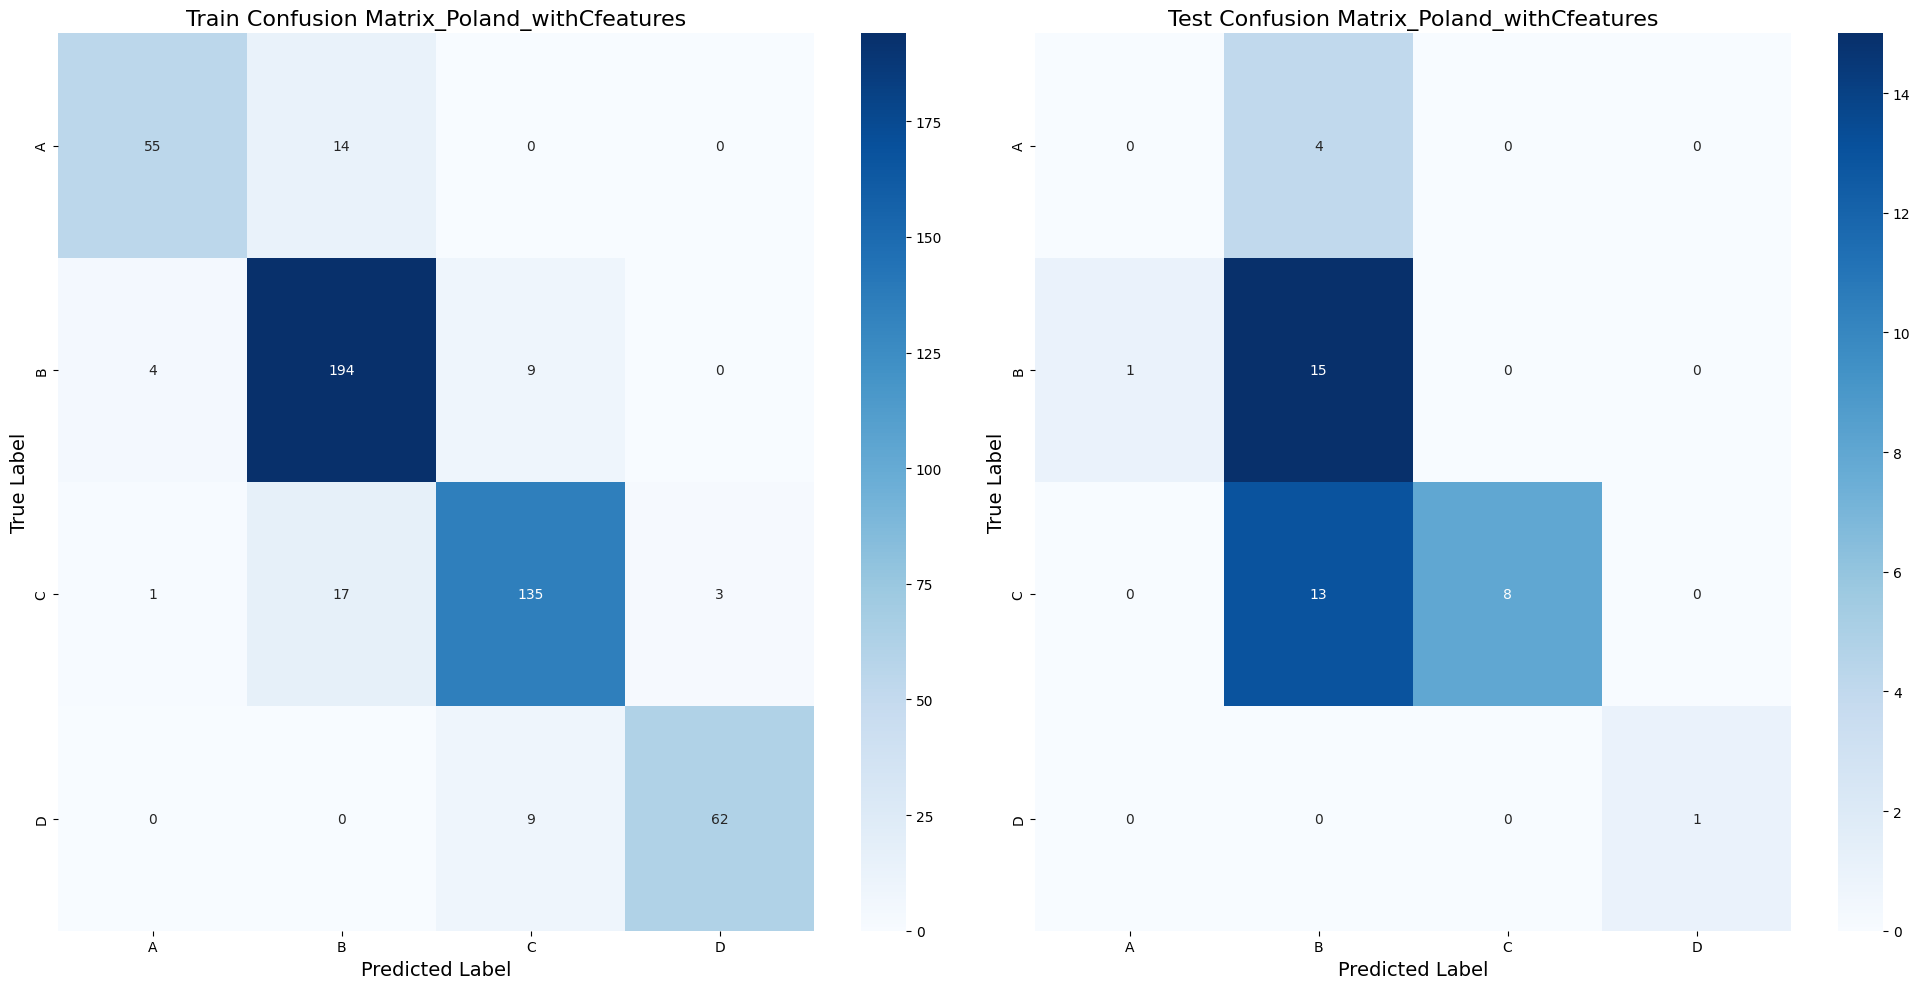

In [6]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Poland_withCfeatures', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matrix_Poland_withCfeatures', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (503, 96, 4)


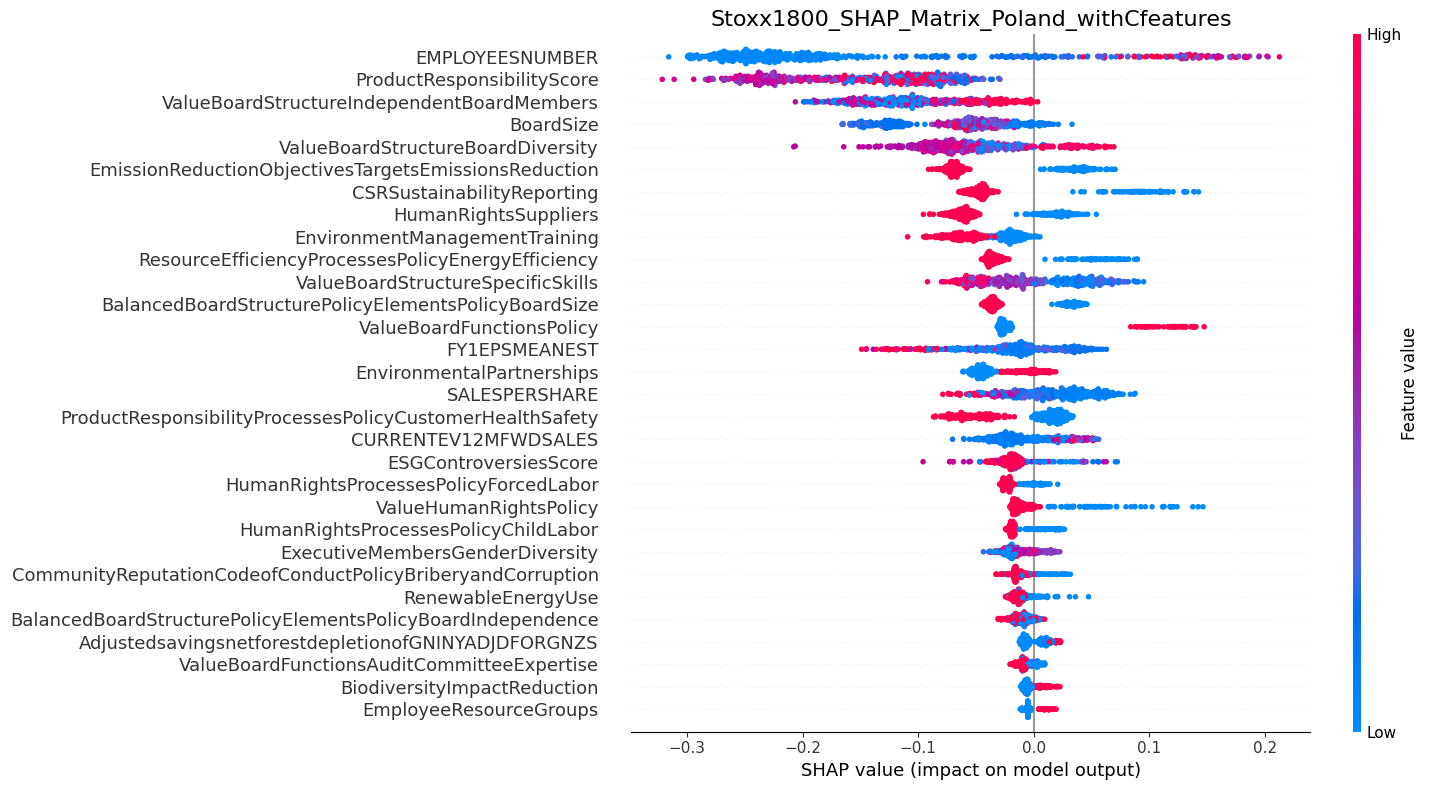

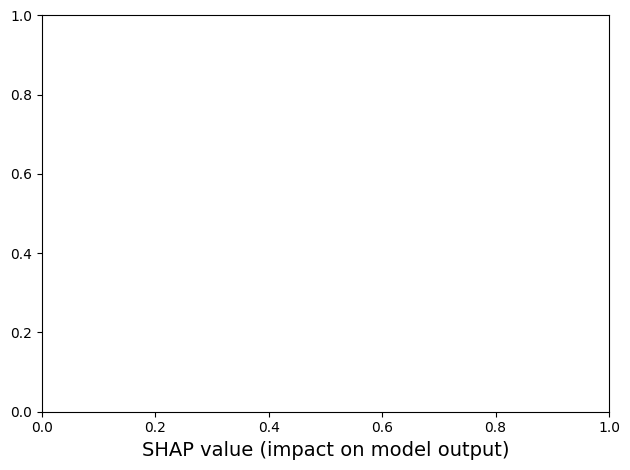

In [7]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Matrix_Poland_withCfeatures", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [30]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8071570576540755 F1 Score: 0.8058931983739944 AUC: 0.9518236966024048 prAUC: 0.8771191170335086
Test Results: Accuracy: 0.5238095238095238 F1 Score: 0.47133138969873667 AUC: 0.8351105413487933 prAUC: 0.729324290236768


In [31]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best Parameters: {'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.1, 'lambda': 3, 'gamma': 1, 'alpha': 2}

Train Results: Accuracy: 0.8349900596421471 F1 Score: 0.8343023877416795 AUC: 0.9601792876852902 prAUC: 0.8952968799528873
Test Results: Accuracy: 0.5476190476190477 F1 Score: 0.5070456754130224 AUC: 0.8363830392143362 prAUC: 0.721230969185441


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8343102325093853, 'gamma': 2, 'learning_rate': 0.41047464734119987, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 579, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.9056020883680015}

Train Results: Accuracy: 0.8389662027833003 F1 Score: 0.8379957163284599 AUC: 0.959225230570127 prAUC: 0.8942449416332217
Test Results: Accuracy: 0.5714285714285714 F1 Score: 0.5541062801932367 AUC: 0.8280547838231109 prAUC: 0.7287464631214304


In [37]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=6,                # 降低树的深度
    n_estimators=579,          # 树的数量
    learning_rate=0.41,        # 降低学习率
    subsample=0.9,             # 样本采样率
    colsample_bytree=0.834,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    min_child_weight=3
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8091451292246521 F1 Score: 0.8081083840711344 AUC: 0.9571355863809838 prAUC: 0.8875628550341632
Test Results: Accuracy: 0.5238095238095238 F1 Score: 0.47316289153023855 AUC: 0.8306435301853534 prAUC: 0.7308826894719


# 4. 南欧及地中海地区

## 4.1 Italy

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Spain','Portugal','Greece','Turkey','Hungary'])]
test_data = data[data['Market'] == 'Italy']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Turkey      117
 Spain        72
 Greece       25
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Italy    128
 Name: count, dtype: int64)

In [5]:
# 分离特征和标签


X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [6]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8227848101265823 F1 Score: 0.8133753567453506 AUC: 0.9555469451009502 prAUC: 0.8964504671714338
Test Results: Accuracy: 0.5703125 F1 Score: 0.48558462771203154 AUC: 0.8098496941101327 prAUC: 0.5737023262582078


In [7]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=30,                # 降低树的深度
    n_estimators=1600,          # 树的数量
    learning_rate=0.2,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9240506329113924 F1 Score: 0.9223280281947496 AUC: 0.9901730426827646 prAUC: 0.9743116850726576
Test Results: Accuracy: 0.609375 F1 Score: 0.5662617247557408 AUC: 0.8263992304243908 prAUC: 0.5933503727110476


In [8]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 2, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500}

Train Results: Accuracy: 0.8143459915611815 F1 Score: 0.8050601379741994 AUC: 0.9557374158516669 prAUC: 0.8974592639510524
Test Results: Accuracy: 0.5703125 F1 Score: 0.48558462771203154 AUC: 0.8147432317166445 prAUC: 0.5817864417612119


In [9]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'lambda': 2, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.8987341772151899 F1 Score: 0.8951720613184342 AUC: 0.9845568150793351 prAUC: 0.9578777479979542
Test Results: Accuracy: 0.59375 F1 Score: 0.5266214244411919 AUC: 0.8139681669262164 prAUC: 0.5767971544314778


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.625 F1 Score: 0.5851323759749393 AUC: 0.8131871787182667 prAUC: 0.5819359675416805


In [27]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=1,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=14,                # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.3,        # 降低学习率
    subsample=0.5,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    #colsample_bylevel=0.84

)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.65625 F1 Score: 0.6217887706018347 AUC: 0.8097532232178125 prAUC: 0.5932578113014584


## 4.2 Spain

In [28]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Portugal','Greece','Turkey','Hungary','Italy'])]
test_data = data[data['Market'] == 'Spain']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Italy       128
 Turkey      117
 Greece       25
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Spain    72
 Name: count, dtype: int64)

In [30]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [31]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.8293515358361775 F1 Score: 0.8270895900726706
Test Results: Accuracy: 0.6111111111111112 F1 Score: 0.5524633123689727


In [32]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:")
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:")



Train Results: Accuracy: 0.9180887372013652 F1 Score: 0.917336585211429 AUC:
Test Results: Accuracy: 0.625 F1 Score: 0.6112484341820568 AUC:


In [33]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8532423208191127 F1 Score: 0.8516751028184979
Test Results: Accuracy: 0.5694444444444444 F1 Score: 0.5255516504081073


In [34]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9215017064846417 F1 Score: 0.9208643490549947
Test Results: Accuracy: 0.5972222222222222 F1 Score: 0.5811043454378595


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.6147547789418131, 'gamma': 0, 'learning_rate': 0.49830747791632646, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 424, 'reg_alpha': 1, 'reg_lambda': 3, 'subsample': 0.8403527257773834}

Train Results: Accuracy: 1.0 F1 Score: 1.0
Test Results: Accuracy: 0.6111111111111112 F1 Score: 0.6131549609810479


In [36]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=7,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=14,                # 降低树的深度
    n_estimators=314,          # 树的数量
    learning_rate=0.3,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42,
    colsmple_bylevel=0.8,

)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


/Applications/hello/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "colsmple_bylevel" } are not used.

  warnings.warn(smsg, UserWarning)



Train Results: Accuracy: 1.0 F1 Score: 1.0
Test Results: Accuracy: 0.6666666666666666 F1 Score: 0.6720538720538721


## 4.3 Greece

In [195]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Portugal','Turkey','Hungary','Italy','Spain'])]
test_data = data[data['Market'] == 'Greece']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Italy       128
 Turkey      117
 Spain        72
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Greece    25
 Name: count, dtype: int64)

In [196]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [197]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8411764705882353 F1 Score: 0.8375524394294981 AUC: 0.9631556159743442 prAUC: 0.9079469256243311
Test Results: Accuracy: 0.52 F1 Score: 0.5048205128205128 AUC: 0.8311111111111111 prAUC: 0.6836129578809809


In [242]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=2,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =2,                   # 添加 gamma 限制分裂
    max_depth=2,                # 降低树的深度
    n_estimators=30,          # 树的数量
    learning_rate=0.03,        # 降低学习率
    #subsample=0.9,             # 样本采样率
    #colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.6823529411764706 F1 Score: 0.664930141473531 AUC: 0.8772766926197207 prAUC: 0.7569909333408262
Test Results: Accuracy: 0.64 F1 Score: 0.5908571428571429 AUC: 0.8068253968253969 prAUC: 0.6538000071823601


In [199]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8647058823529412 F1 Score: 0.8624027151249591 AUC: 0.9698245526388718 prAUC: 0.92393755954245
Test Results: Accuracy: 0.48 F1 Score: 0.4577094017094017 AUC: 0.8311507936507937 prAUC: 0.6758824618364091


In [200]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 定义参数分布，仅调整 max_depth、n_estimators 和 learning_rate
param_dist = {
    'max_depth': [15,20,25,30],
    'n_estimators': [300,500, 1000, 1200,1500],
    'learning_rate': [0.01, 0.05, 0.1,0.2],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3],
    'gamma': [1,2,3]
}

# 初始化 XGBoost 模型，保持其他参数不变
xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 RandomizedSearchCV 进行随机参数搜索
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='f1_weighted', cv=3, 
                                   n_jobs=-1, verbose=1, n_iter=30, random_state=42)  # 可以调整 n_iter 以控制搜索次数
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=1,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 1500, 'max_depth': 20, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 1, 'alpha': 1}

Train Results: Accuracy: 0.9205882352941176 F1 Score: 0.9195876837405621 AUC: 0.9914864906905174 prAUC: 0.9752129214730421
Test Results: Accuracy: 0.44 F1 Score: 0.41303703703703704 AUC: 0.8162301587301587 prAUC: 0.6449106368716055


In [201]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=3,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=1
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8139902314521446, 'gamma': 0, 'learning_rate': 0.05474749569755443, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 799, 'reg_alpha': 2, 'reg_lambda': 9, 'subsample': 0.6048532180808106}

Train Results: Accuracy: 0.9823529411764705 F1 Score: 0.9820371449877551 AUC: 0.9995599945725888 prAUC: 0.9966624711874685
Test Results: Accuracy: 0.48 F1 Score: 0.4628811188811188 AUC: 0.8125396825396826 prAUC: 0.6540840626521741


In [202]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9147058823529411 F1 Score: 0.9136542497968764 AUC: 0.99041481305683 prAUC: 0.970129997543892
Test Results: Accuracy: 0.4 F1 Score: 0.33125925925925925 AUC: 0.8357936507936508 prAUC: 0.682875525210084


## 4.4 Portugal

In [2]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Spain','Greece','Turkey','Hungary','Italy'])]
test_data = data[data['Market'] == 'Portugal']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Italy      128
 Turkey     117
 Spain       72
 Greece      25
 Hungary      7
 Name: count, dtype: int64,
 Market
 Portugal    16
 Name: count, dtype: int64)

In [3]:
# 分离特征和标签
X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)


# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [44]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
   
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.8424068767908309 F1 Score: 0.8401372793312293
Test Results: Accuracy: 0.75 F1 Score: 0.7593167701863354


In [4]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 0.9197707736389685 F1 Score: 0.9190369674079553
Test Results: Accuracy: 0.8125 F1 Score: 0.8125


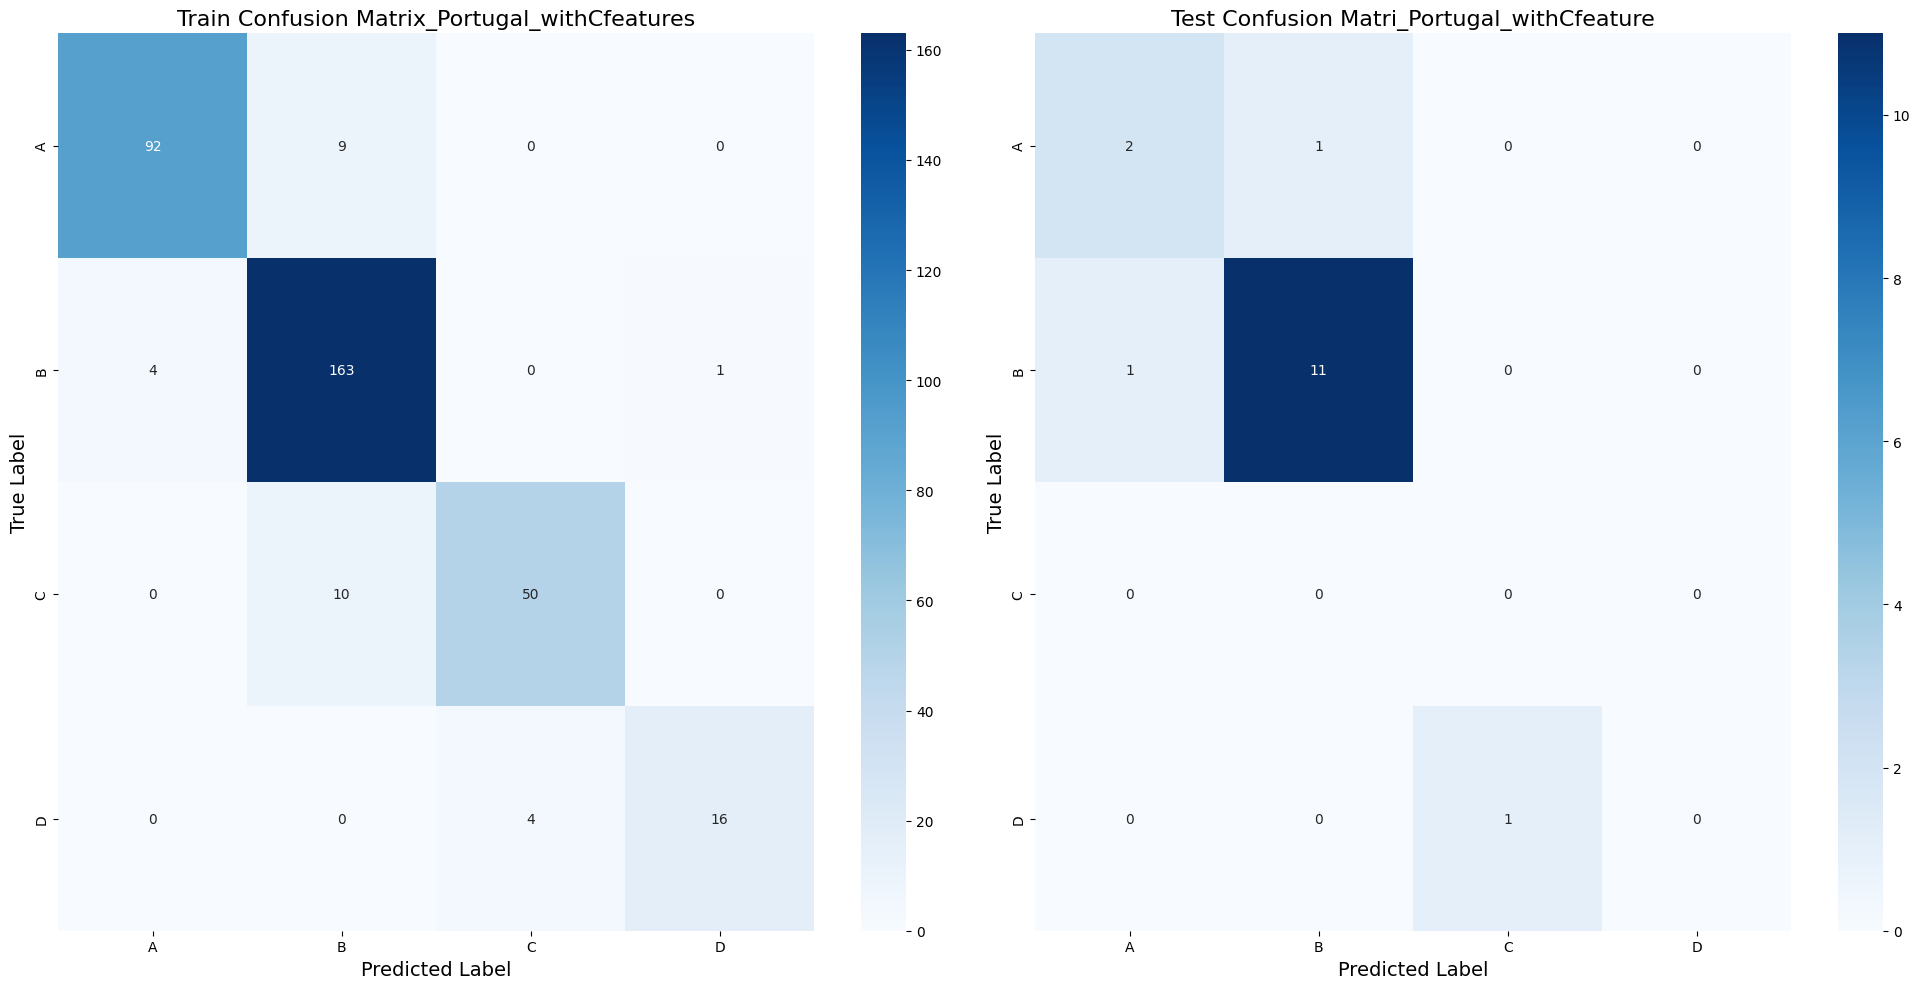

In [7]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# 绘制训练集和测试集的混淆矩阵
y_train_pred = tuned_xgb_model.predict(X_train)
y_test_pred = tuned_xgb_model.predict(X_test)

conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(20, 10))

# 训练集混淆矩阵
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Train Confusion Matrix_Portugal_withCfeatures', fontsize=16)

# 测试集混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Test Confusion Matri_Portugal_withCfeature', fontsize=16)

plt.tight_layout()
plt.show()


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (349, 92, 4)


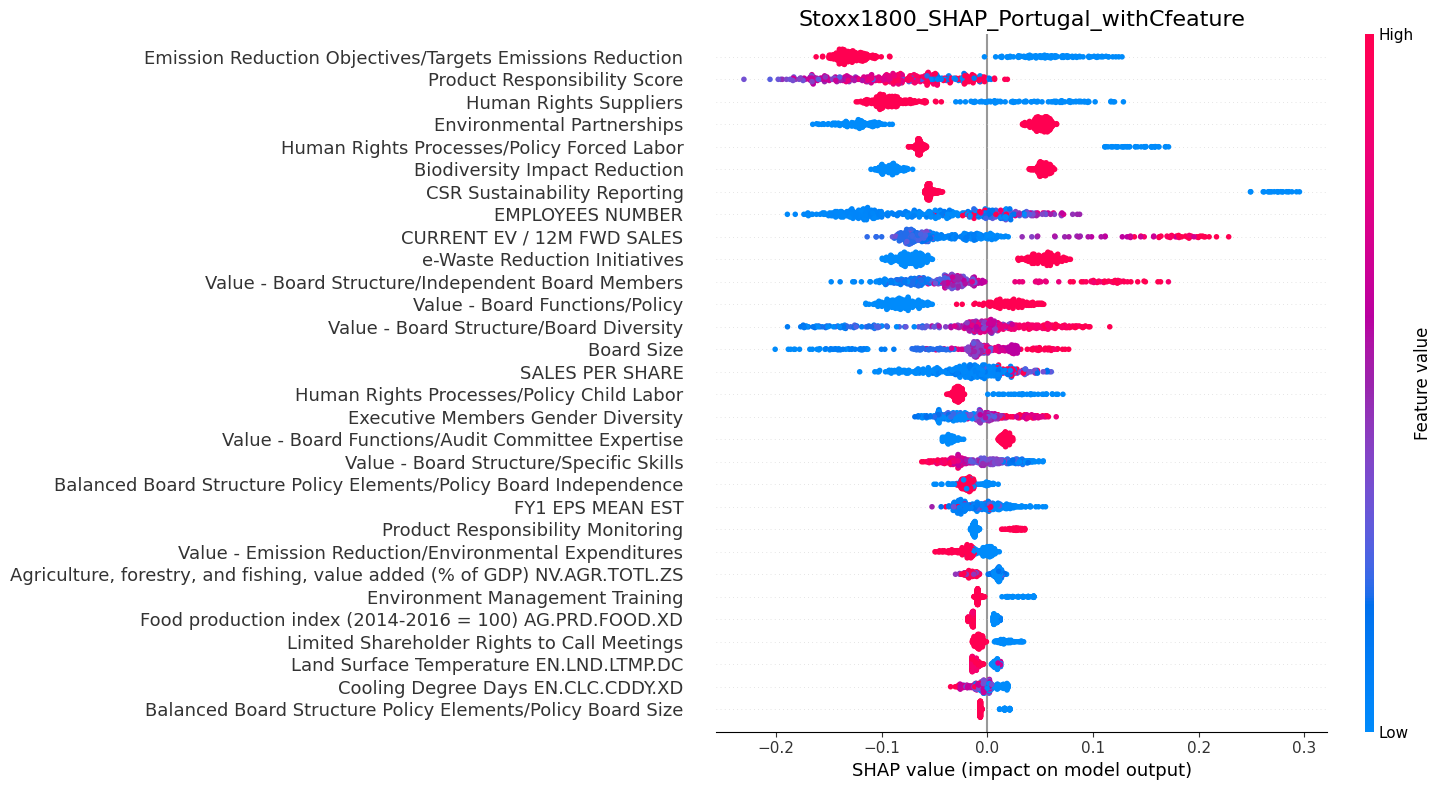

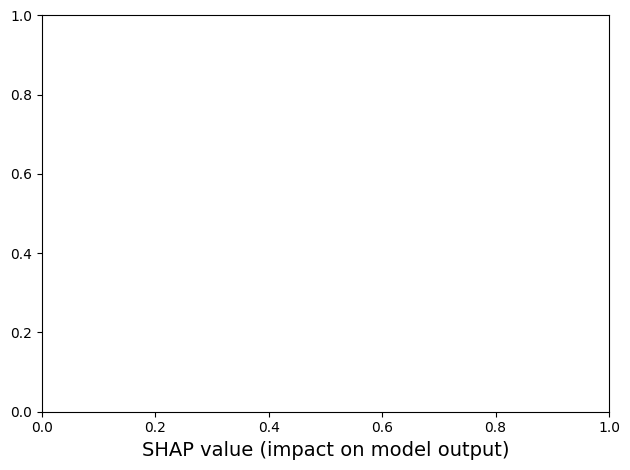

In [8]:
import shap
import matplotlib.pyplot as plt

# 使用 SHAP 解释器计算 SHAP 值
explainer = shap.TreeExplainer(tuned_xgb_model)
shap_values = explainer.shap_values(X_train)

# 输出 shap_values 的类型和形状
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values shape (for each class):", [sv.shape for sv in shap_values])
else:
    print("SHAP values shape:", shap_values.shape)

# 确保 feature_names 被定义
feature_names = X_train.columns

# 绘制总体 SHAP summary plot
# 将 SHAP 值按类别进行平均，得到总体 SHAP 值
shap_values_mean = shap_values.mean(axis=2)

plt.figure(figsize=(15, 8))  # 增大图形尺寸
plt.title("Stoxx1800_SHAP_Portugal_withCfeature", fontsize=16)  # 增大标题字体
shap.summary_plot(shap_values_mean, X_train, feature_names=feature_names, max_display=30, plot_size=(15, 8))
plt.xlabel("SHAP value (impact on model output)", fontsize=14)  # 增大x轴标签字体
plt.tight_layout()  # 自动调整布局
plt.show()  # 显示图形

In [46]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8653295128939829 F1 Score: 0.863940261323445
Test Results: Accuracy: 0.75 F1 Score: 0.7593167701863354


In [47]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1200}

Train Results: Accuracy: 0.8653295128939829 F1 Score: 0.863940261323445
Test Results: Accuracy: 0.75 F1 Score: 0.7593167701863354


In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.8473015537351571, 'gamma': 0, 'learning_rate': 0.3378613176903711, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 314, 'reg_alpha': 1, 'reg_lambda': 7, 'subsample': 0.5590824138108281}

Train Results: Accuracy: 1.0 F1 Score: 1.0
Test Results: Accuracy: 0.8125 F1 Score: 0.8125


In [54]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=7,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=20,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.05,        # 降低学习率
    subsample=0.55,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    
    return accuracy, f1

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1])



Train Results: Accuracy: 1.0 F1 Score: 1.0
Test Results: Accuracy: 0.8125 F1 Score: 0.8125


## 4.5 Turkey

In [243]:
data = pd.read_csv('merged_all_features_with_worldbank_suppliment_v1.csv')
# 筛选出中国、香港和韩国的数据作为训练集，日本的数据作为测试集
train_data = data[data['Market'].isin(['Spain','Portugal','Greece','Hungary','Italy'])]
test_data = data[data['Market'] == 'Turkey']
# 查看每个国家的数据量
train_data_counts = train_data['Market'].value_counts()
test_data_counts = test_data['Market'].value_counts()

train_data_counts, test_data_counts

(Market
 Italy       128
 Spain        72
 Greece       25
 Portugal     16
 Hungary       7
 Name: count, dtype: int64,
 Market
 Turkey    117
 Name: count, dtype: int64)

In [244]:
# 分离特征和标签

X_train = train_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_train = train_data['ESG_Rating']
X_test = test_data.drop(columns=['ESG_Rating', 'Market', 'Type','Country Name','Country Code'])
y_test = test_data['ESG_Rating']

X_train.columns = X_train.columns.str.replace(r"[\[\]<]", "", regex=True)
X_train.columns = X_train.columns.astype(str)

# 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# 使用 pd.get_dummies() 将类别变量转换为数值
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练和测试集的列一致（在某些情况下，可能需要重新对齐）
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [57]:
# baselin参数
# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma=2,                   # 添加 gamma 限制分裂
    max_depth=4,               # 降低树的深度
    n_estimators=300,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.8064516129032258 F1 Score: 0.7962232659813304 AUC: 0.9624434345851157 prAUC: 0.9170728503023755
Test Results: Accuracy: 0.4017094017094017 F1 Score: 0.2649572649572649 AUC: 0.8265099566900614 prAUC: 0.6788383283406532


In [58]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =1,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=1200,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 0.9354838709677419 F1 Score: 0.9348669159998544 AUC: 0.9919947669529809 prAUC: 0.9821521933021268
Test Results: Accuracy: 0.4188034188034188 F1 Score: 0.3020887419332179 AUC: 0.8109930666908667 prAUC: 0.656504805784994


In [59]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格，仅调整 max_depth、n_estimators 和 learning_rate
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.1],
    'alpha': [1, 2, 3],
    'lambda': [1, 2, 3]
}

# 初始化 XGBoost 模型，设置其他参数保持不变
xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42
)

# 使用 GridSearchCV 进行参数搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置重新训练模型
tuned_xgb_model = xgb.XGBClassifier(
    gamma=2,
    subsample=0.6,
    colsample_bytree=0.8,
    objective='multi:softprob',
    random_state=42,
    **best_params  # 使用最佳参数
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'alpha': 1, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}

Train Results: Accuracy: 0.8387096774193549 F1 Score: 0.8331348512987197 AUC: 0.9691768222380863 prAUC: 0.937591535689735
Test Results: Accuracy: 0.42735042735042733 F1 Score: 0.2940958220620791 AUC: 0.8291874003116405 prAUC: 0.686659238547209


In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 定义参数分布范围
param_dist = {
    'max_depth': randint(5,16),                # 树的最大深度，随机从 4 到 10 之间选择
    'min_child_weight': randint(1, 10),         # 子节点最小权重，随机从 1 到 10 之间选择
    'subsample': uniform(0.5, 0.5),             # 样本采样率，随机从 0.5 到 1.0 之间选择
    'colsample_bytree': uniform(0.6, 0.4),      # 特征采样率，随机从 0.6 到 1.0 之间选择
    'n_estimators': randint(200, 800),         # 树的数量，随机从 500 到 1500 之间选择
    'learning_rate': uniform(0.01, 0.5),        # 学习率，随机从 0.01 到 0.1 之间选择
    'gamma': randint(0, 5),                     # gamma 参数，随机从 0 到 5 之间选择
    'reg_alpha': randint(1, 8),                # L1 正则化参数，随机从 1 到 10 之间选择
    'reg_lambda': randint(1, 10)                # L2 正则化参数，随机从 1 到 10 之间选择
}

# 初始化 XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)

# 设置 RandomizedSearch CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                      # 随机采样 50 组参数
    scoring='f1_weighted',          # 使用加权 F1 分数作为评估指标
    cv=3,                           # 3 折交叉验证
    random_state=42,
    n_jobs=-1,                      # 使用所有可用的 CPU 核心
    verbose=1
)

# 运行 RandomizedSearchCV
random_search.fit(X_train, y_train)

# 输出最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 使用最佳参数配置初始化并重新训练 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    random_state=42
)

tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 评估模型性能
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, label_binarize(y_train, classes=[0, 1, 2, 3]))
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, label_binarize(y_test, classes=[0, 1, 2, 3]))

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.7693605922825478, 'gamma': 0, 'learning_rate': 0.1093578407670862, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 792, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8856351733429728}

Train Results: Accuracy: 0.9919354838709677 F1 Score: 0.9918406951344134 AUC: 0.99978929341133 prAUC: 0.9990943596757851
Test Results: Accuracy: 0.4358974358974359 F1 Score: 0.3278753488574917 AUC: 0.8110912063171917 prAUC: 0.6491270837961765


In [70]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=12,                # 降低树的深度
    n_estimators=800,          # 树的数量
    learning_rate=0.1,        # 降低学习率
    subsample=0.6,             # 样本采样率
    colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.46153846153846156 F1 Score: 0.37225058149907014 AUC: 0.7980891418660786 prAUC: 0.6364389347253833


In [262]:

# 使用最佳参数配置初始化 XGBoost 模型
tuned_xgb_model = xgb.XGBClassifier(
    reg_alpha=1,               # L1 正则化
    reg_lambda=2,              # L2 正则化
    gamma =0,                   # 添加 gamma 限制分裂
    max_depth=10,                # 降低树的深度
    n_estimators=800,          # 树的数量
    learning_rate=0.04,        # 降低学习率
    subsample=0.5,             # 样本采样率
    #colsample_bytree=0.8,      # 特征采样率
    objective='multi:softprob',
    random_state=42
)


# 训练模型
tuned_xgb_model.fit(X_train, y_train, verbose=True)

# 二值化标签，以便计算多类 ROC AUC 和 prAUC
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 定义 evaluate_model 函数
def evaluate_model(model, X, y, y_binarized):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y_binarized, y_pred_proba, multi_class="ovr")
    pr_auc = average_precision_score(y_binarized, y_pred_proba)
    
    return accuracy, f1, auc, pr_auc

# 训练集和测试集的评估
train_results = evaluate_model(tuned_xgb_model, X_train, y_train, y_train_binarized)
test_results = evaluate_model(tuned_xgb_model, X_test, y_test, y_test_binarized)

# 输出评估结果
print("\nTrain Results: Accuracy:", train_results[0], "F1 Score:", train_results[1], "AUC:", train_results[2], "prAUC:", train_results[3])
print("Test Results: Accuracy:", test_results[0], "F1 Score:", test_results[1], "AUC:", test_results[2], "prAUC:", test_results[3])



Train Results: Accuracy: 1.0 F1 Score: 1.0 AUC: 1.0 prAUC: 1.0
Test Results: Accuracy: 0.48717948717948717 F1 Score: 0.3990289927936987 AUC: 0.7928259791241421 prAUC: 0.6290763232489546
